In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [37]:
# naložimo podatke in jih shranimo v DataFrame data
data = pd.read_csv("Diamonds.csv")

In [38]:
# odstranimo stolpec Unnamed: 0	
data = data.drop("Unnamed: 0", axis = 1)

In [39]:
# preverimo ali data vsebuje NaN vrednosti
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [40]:
# podatkovno množico razdelimo na kategorično in numerično ter ciljno
cat = data[["cut", "color", "clarity"]]
num = data[["carat", "depth", "table", "x", "y", "z"]]
target = data["price"]

In [41]:
# pretvorimo kategorične vrednosti v numerične
le = LabelEncoder()
for i in range(len(cat.columns)):
    cat.iloc[:, i] = le.fit_transform(cat.iloc[:, i])

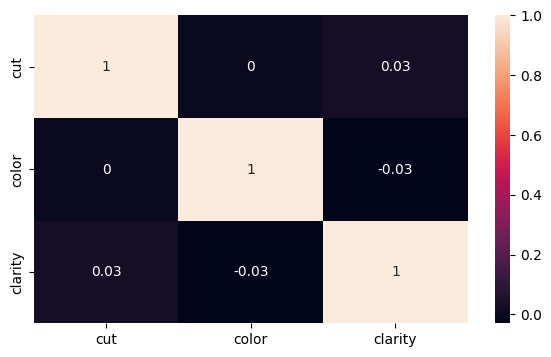

In [42]:
# korelacijska matrika za kategorične spremeljivk
plt.figure(figsize=(7, 4))
sns.heatmap(np.round(cat.corr(), 2), annot = True)
plt.show()

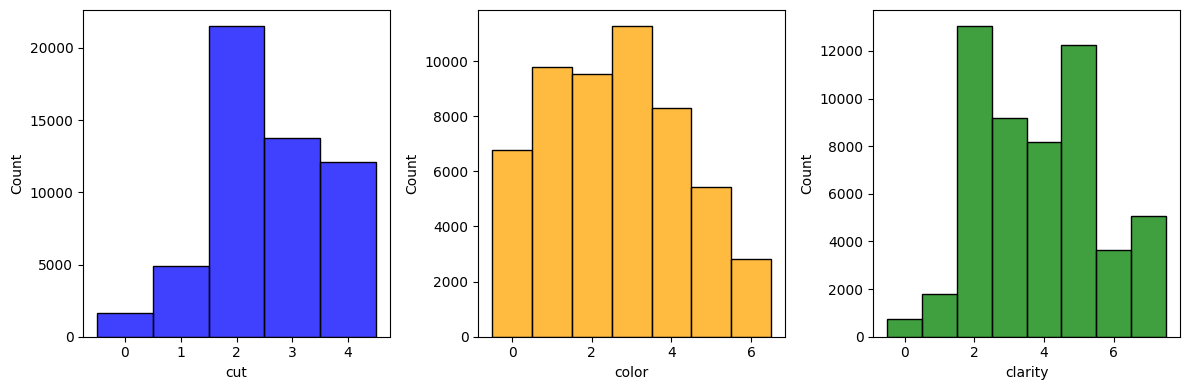

In [43]:
# histogrami kategoričnih spremenljivk
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(cat.iloc[:, 0], color = 'blue', discrete = True, ax = axs[0])
sns.histplot(cat.iloc[:, 1], color = 'orange', discrete = True, ax = axs[1])
sns.histplot(cat.iloc[:, 2], color = 'green', discrete = True, ax = axs[2])
plt.tight_layout()
plt.show()

In [44]:
# transformiramo numerične spremenljivke tako da bodo centralizirane in čim bolj "normalne"
# oprabimo zamanknjeno Yeo-Johnson transformacijo
pt = PowerTransformer(method = 'yeo-johnson')
num = pd.DataFrame(pt.fit_transform(num), columns = num.columns, index = num.index)

In [45]:
# odstranim outlierje 
num["dist"] = num.pow(2).sum(axis = 1)**(1/2)
threshold = np.percentile(num["dist"], 95)
num = num[num["dist"] <= threshold]
num.drop("dist", axis = 1, inplace = True)

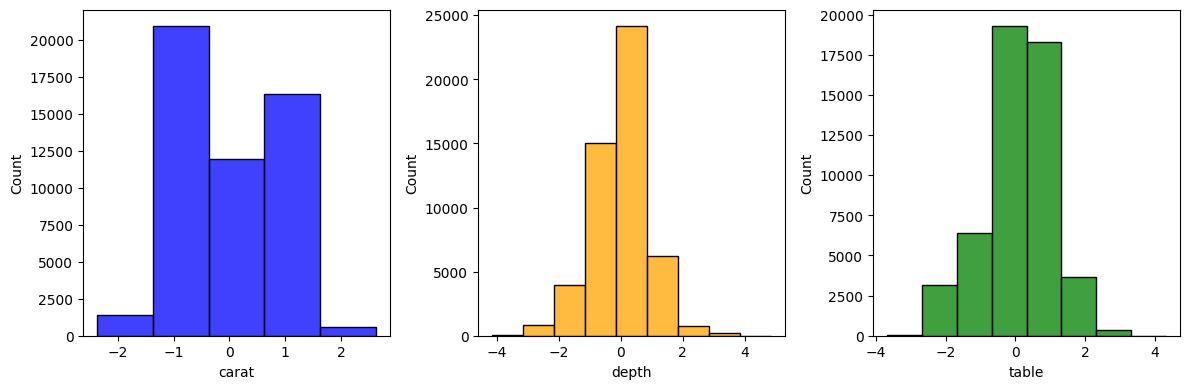

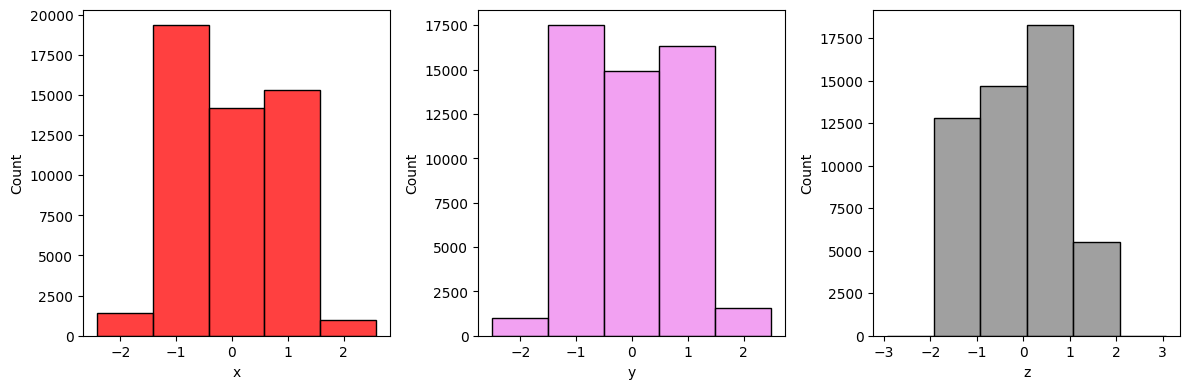

In [46]:
# histogrami numeričnih spremenljivk
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(num.iloc[:, 0], color = 'blue', discrete = True, ax = axs[0])
sns.histplot(num.iloc[:, 1], color = 'orange', discrete = True, ax = axs[1])
sns.histplot(num.iloc[:, 2], color = 'green', discrete = True, ax = axs[2])
plt.tight_layout()
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(num.iloc[:, 3], color = 'red', discrete = True, ax = axs[0])
sns.histplot(num.iloc[:, 4], color = 'violet', discrete = True, ax = axs[1])
sns.histplot(num.iloc[:, 5], color = 'grey', discrete = True, ax = axs[2])
plt.tight_layout()
plt.show()

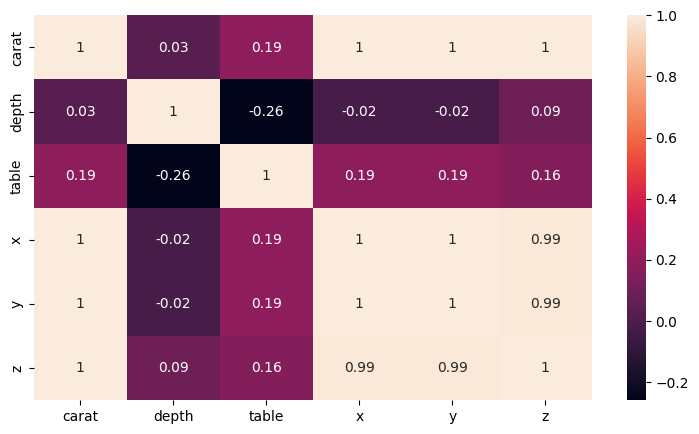

In [47]:
# korelacijska matrika za numeričnih spremeljivk
plt.figure(figsize=(9, 5))
sns.heatmap(np.round(num.corr(), 2), annot = True)
plt.show()

In [48]:
# ker so x, y, z, carat zelo korelirane jih s pomočjo PCA združimo v eno spremenljivko
pca = PCA()
num_pca = pca.fit_transform(num[["x", "y", "z", "carat"]])

# pojasnjena varance prve je zelo visoka, tako da lahko štiri spremenljivke združimo v eno
print(pca.explained_variance_ratio_)

# odtranimo  x, y, z, carat in dodamo novo spremenljivko pc
num["pc"] = num_pca[:, 0]
num.drop(["x", "y", "z", "carat"], axis = 1, inplace = True)

[9.96992424e-01 2.30895265e-03 4.03905288e-04 2.94717631e-04]


In [49]:
# kategorične, numerične in ciljne podatke združimo v DataFrame df
df = pd.concat([cat, num, target], axis = 1).dropna(axis = 0)
df

,cut,color,clarity,depth,table,pc,price
0,2,1,3,-0.180479,-1.173388,-3.320495,326
3,3,5,5,0.449235,0.344180,-2.698175,334
4,1,6,3,1.084044,0.344180,-2.402268,335
5,4,6,7,0.730745,-0.116572,-3.267039,336
6,4,5,6,0.379014,-0.116572,-3.257821,336
...,...,...,...,...,...,...,...
53935,2,0,2,-0.666714,-0.116572,0.293981,2757
53936,1,0,2,0.942537,-1.173388,0.340353,2757
53937,4,0,2,0.730745,1.152387,0.234252,2757
53938,3,4,3,-0.528107,0.344180,0.956376,2757


In [50]:
# df razdelimo na napovedne podatke X in napovedno odvisno spremenljivko Y
X = df[df.columns.difference(["price"])].to_numpy()
y = df["price"].to_numpy()

In [51]:
# uporabimo CV metodo za napoved napake na testni množici, metrika je root sqrt(mean_squared_error)
def CV(model, X, y):
    kfold = KFold(n_splits = 5, random_state = 9, shuffle = True)
    errors = []
    
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]
        y_pred = model.fit(X_train, y_train).predict(X_test)
        errors.append(mean_squared_error(y_test, y_pred)**(1/2))
        
    return errors, np.mean(errors)

In [52]:
CV(XGBRegressor(), X, y)

([443.06042374046444,
  450.93211032723434,
  455.7055267067651,
  454.9603487196356,
  470.1290735601716],
 454.9574966108542)